In [55]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

In [56]:
df = pd.read_csv('compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [57]:
print(df.isnull().sum())
df.columns

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [58]:
# STEP 1: Clean categorical values (e.g., 'race')
# Map 'race' to binary: 1 = unprivileged (Black), 0 = privileged (White)
columns_to_drop = [
    'id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
    'age', 'age_cat', 'juv_fel_count', 'decile_score',
    'juv_misd_count', 'juv_other_count', 'priors_count',
    'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
    'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
    'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
    'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
    'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
    'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
    'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
    'decile_score.1', 'score_text', 'screening_date',
    'v_type_of_assessment', 'v_decile_score', 'v_score_text',
    'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
    'start', 'end', 'event'
]

df = df.drop(columns=columns_to_drop, errors='ignore')  # Avoid error if some columns are missing
df['race'] = df['race'].map({'African-American': 1, 'Caucasian': 0})

# Drop rows with undefined race (e.g., 'Hispanic', 'Other', NaN)
df = df[df['race'].isin([0, 1])]

# Ensure 'two_year_recid' is float (favorable = 0, unfavorable = 1)
df['two_year_recid'] = df['two_year_recid'].astype(float)

# Drop or encode other non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=non_numeric_cols)

In [59]:
# Convert new_df (your Pandas DataFrame) into a BinaryLabelDataset
# STEP 2: Convert to BinaryLabelDataset
dataset = BinaryLabelDataset(
    df=df,
    label_names=['two_year_recid'],
    protected_attribute_names=['race'],
    favorable_label=0.0,
    unfavorable_label=1.0
)


In [60]:
# STEP 3: Split into train/test sets
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

# STEP 4: Evaluate fairness metric
unprivileged_groups = [{'race': 1}]
privileged_groups = [{'race': 0}]

metric = BinaryLabelDatasetMetric(dataset_test,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("Statistical parity difference (pre-mitigation):", metric.statistical_parity_difference())

Statistical parity difference (pre-mitigation): -0.12632131675287323


In [61]:
# Reweighing mitigation
RW = Reweighing(unprivileged_groups=[{'race': 1}], privileged_groups=[{'race': 0}])
dataset_train_transf = RW.fit_transform(dataset_train)

# Train classifier
scaler = StandardScaler()
X_train = scaler.fit_transform(dataset_train_transf.features)
y_train = dataset_train_transf.labels.ravel()

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [62]:
# Evaluate on test set
X_test = scaler.transform(dataset_test.features)
y_pred = model.predict(X_test)

# Wrap predictions
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)

# Bias metrics
metric_pred = ClassificationMetric(dataset_test, dataset_pred,
                                   unprivileged_groups=[{'race': 1}],
                                   privileged_groups=[{'race': 0}])

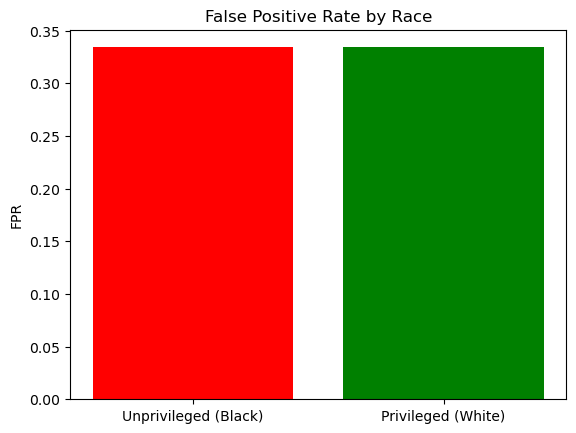

In [63]:
# Visualization: False Positive Rate
fpr_unpriv = metric_pred.false_positive_rate()
fpr_priv = metric_pred.false_positive_rate()

plt.bar(['Unprivileged (Black)', 'Privileged (White)'], [fpr_unpriv, fpr_priv], color=['red', 'green'])
plt.title('False Positive Rate by Race')
plt.ylabel('FPR')
plt.show()